In [ ]:
# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, Conv2D, MaxPooling2D, TimeDistributed
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [3]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

# Get all the data out of datetime
# Could also get holiday data: https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

#df['month'] = df.index.month
#df['week'] = df.index.week
#df['day'] = df.index.day
#df['year'] = df.index.year

#df['month_end'] = df.index.is_month_end
#df['month_start'] = df.index.is_month_start
#df['quarter_end'] = df.index.is_quarter_end
#df['quarter_start'] = df.index.is_quarter_start



In [4]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,TD,U,VV,WW,gasPower,dwelling,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22 12:00:00,87.033333,0.0,240.149994,0.0,11.266666,16.063334,6.000000,1006.333313,90.166664,0.000000,...,8.216666,86.833336,14500.000000,2.000000,1.001953,All dwellings,NaN,12,2,1
2017-02-22 13:00:00,92.240356,0.0,236.633331,464.0,10.581667,15.056667,6.833333,1006.016663,71.333336,0.200000,...,8.400000,89.500000,11551.666992,63.333332,0.000000,All dwellings,NaN,13,2,1
2017-02-22 14:00:00,93.821724,0.0,234.149994,196.0,10.683333,15.986667,7.833333,1005.483337,91.500000,0.033333,...,8.516666,92.000000,11733.333008,48.500000,0.000000,All dwellings,NaN,14,2,1
2017-02-22 15:00:00,133.030640,0.0,237.500000,190.0,11.036667,16.288334,7.666667,1004.983337,51.500000,0.050000,...,8.500000,91.833336,12416.666992,49.000000,0.000000,All dwellings,NaN,15,2,1
2017-02-22 16:00:00,111.652779,0.0,237.649994,562.0,10.688334,14.911667,7.666667,1004.650024,26.833334,0.616667,...,8.533334,92.833336,7686.666504,71.166664,0.769043,All dwellings,NaN,16,2,1


Saving heatmap


<Figure size 432x288 with 0 Axes>

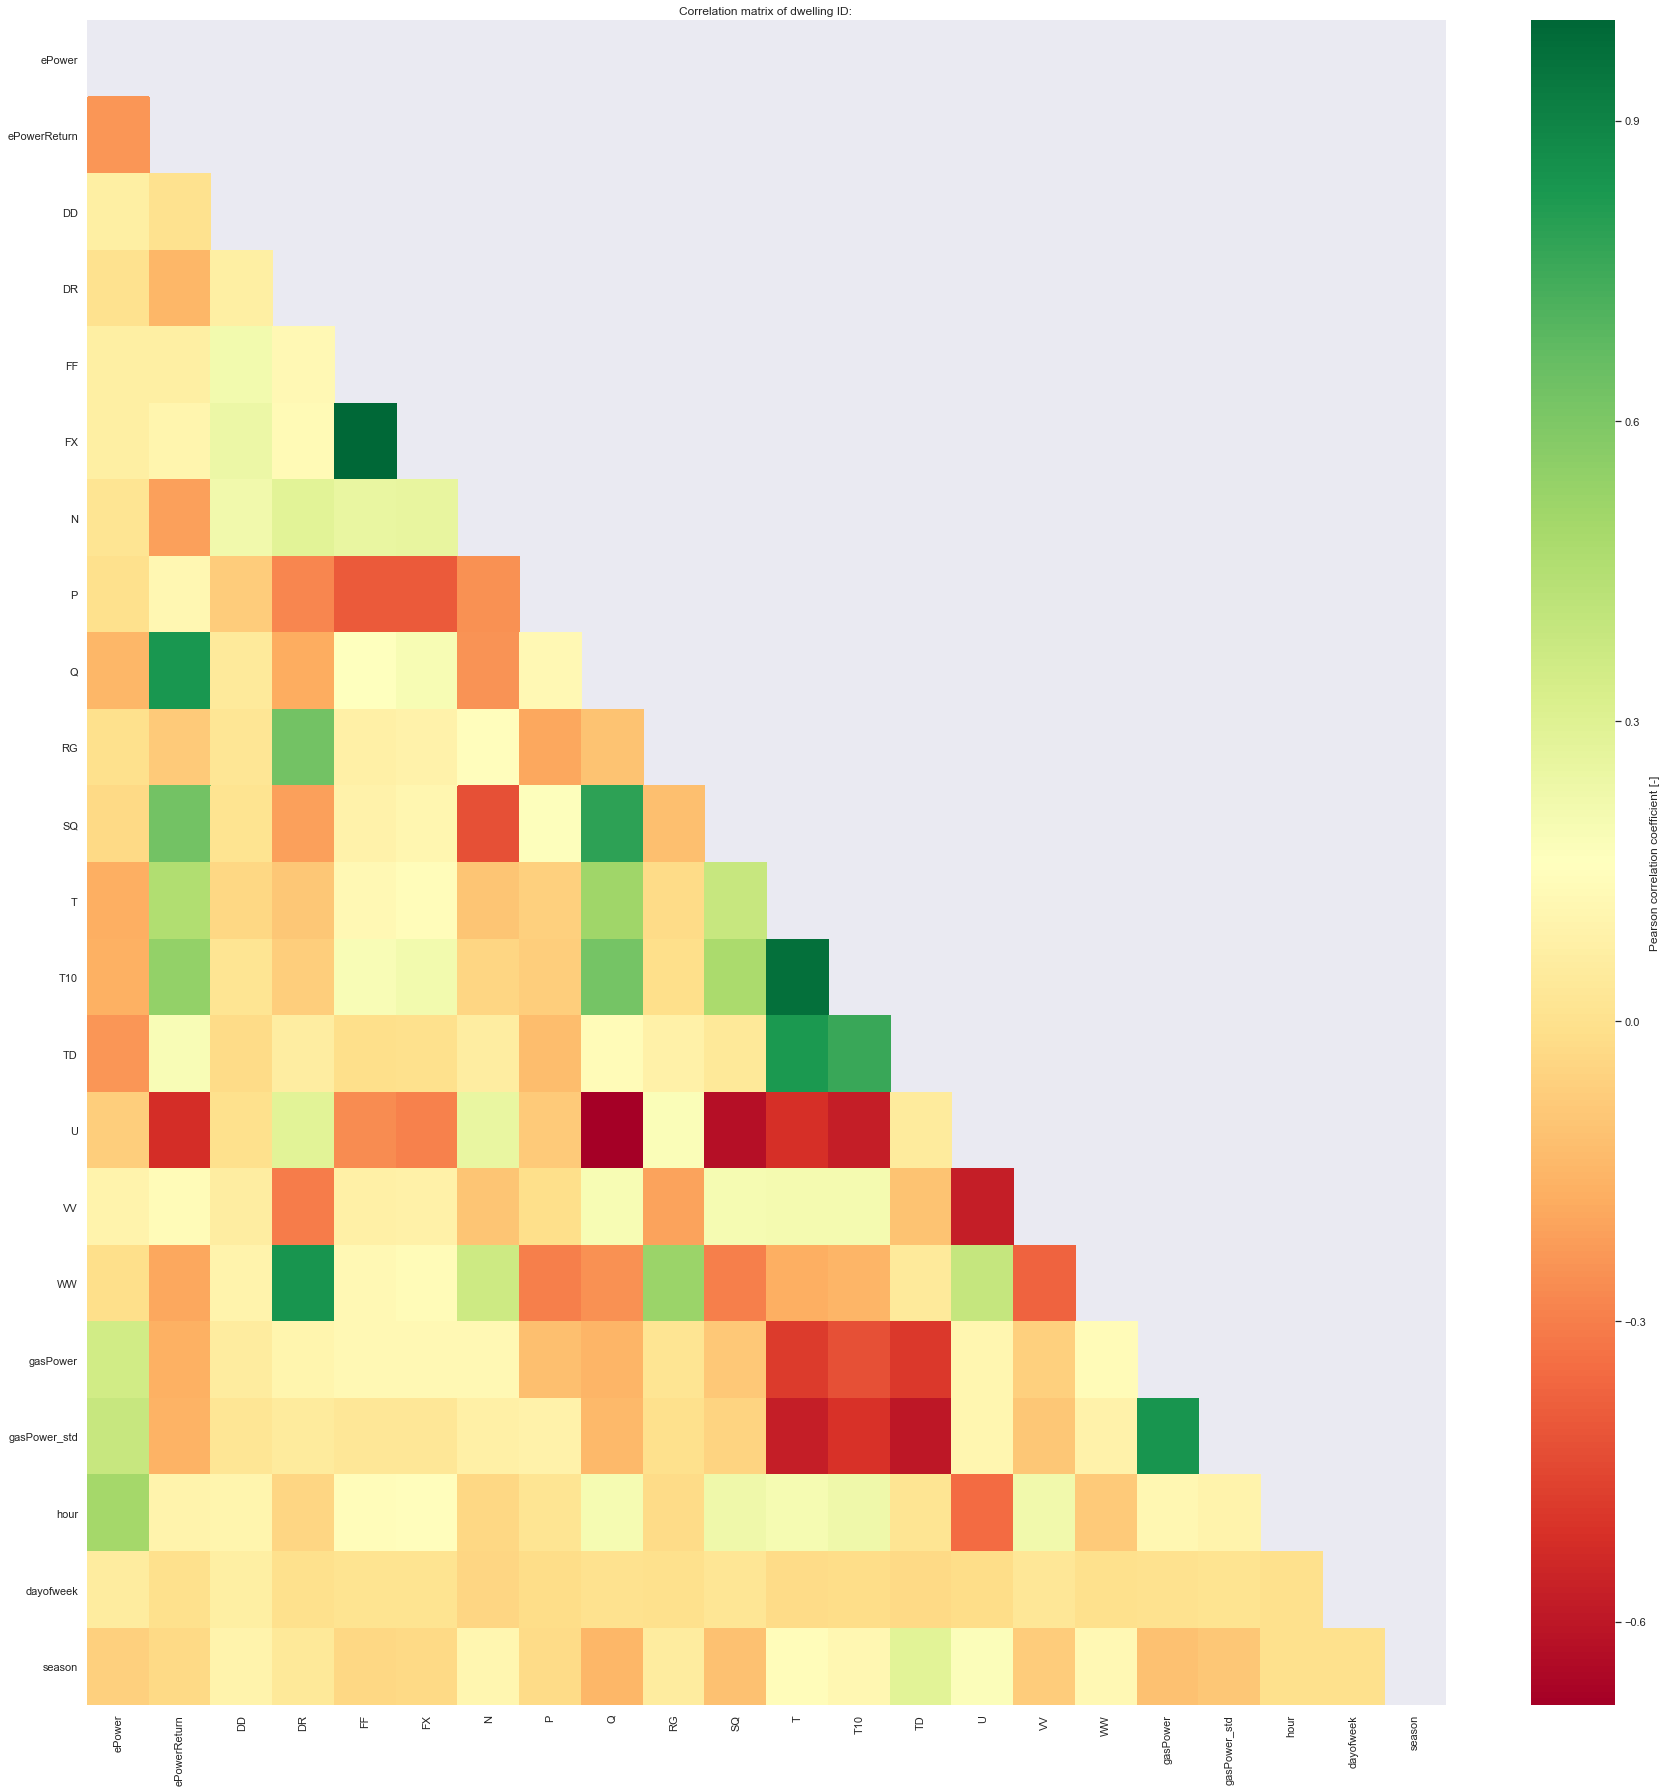

In [5]:
fig = create_corr_matrix(df, '', False)

# Select data to use

Saving heatmap
Len of data:  6352


<Figure size 432x288 with 0 Axes>

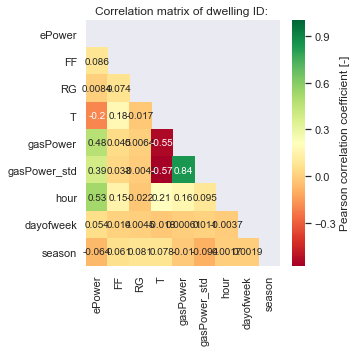

In [6]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

#data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower
data = data.drop(['ePowerReturn'], axis=1)


# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

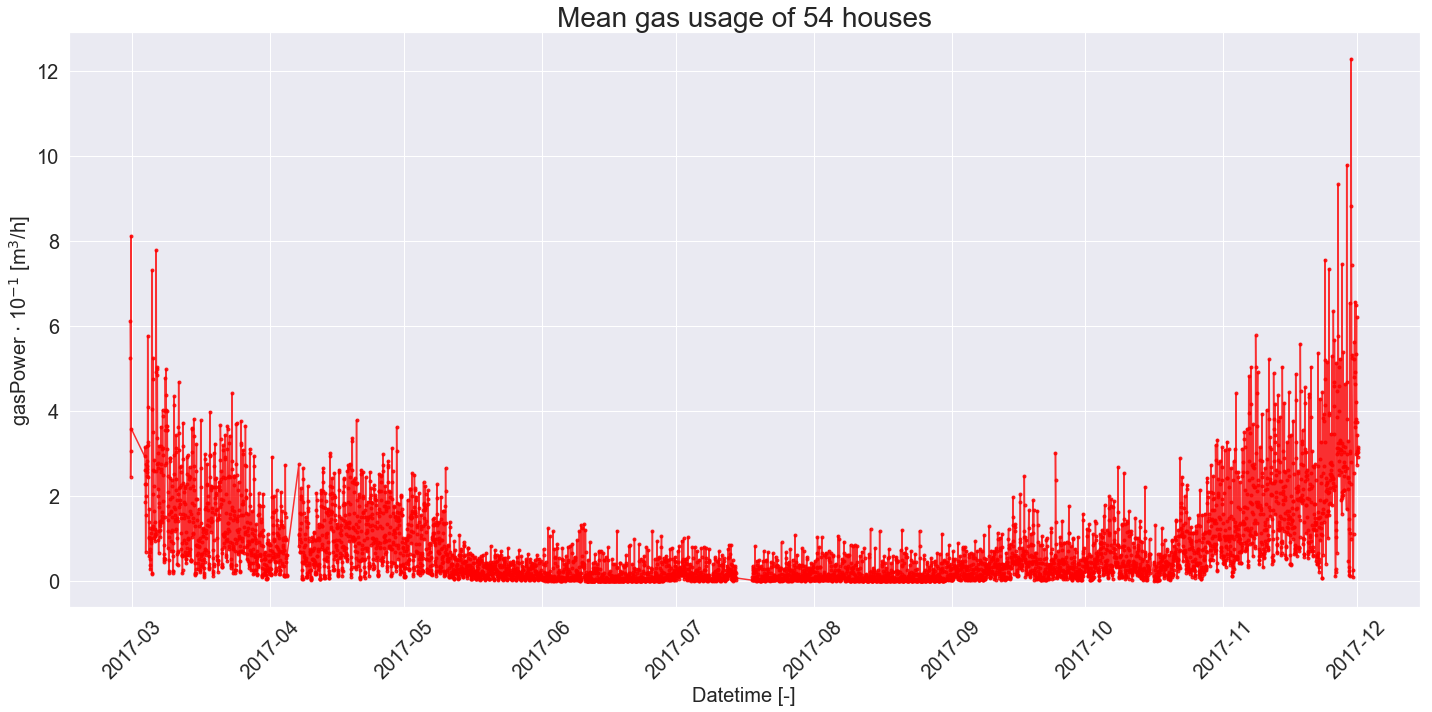

In [7]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Mean gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# Preprocessing

In [8]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']

data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season,gasPower_copy
datetime,,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1,6.115723
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1,5.238647
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1,2.451172
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1,3.065186
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1,8.120117


In [9]:
#data = create_timeseries_history(data, columns_to_lookback=data.columns, n_lookback=5, dropnan=True)

In [10]:
data = reduce_memory(data)

100%|██████████| 10/10 [00:00<00:00, 4007.17it/s]

Memory uasge reduced from 0.001 GB to 0.000 GB


# datetime info to categorical

In [11]:
data.columns

Index(['ePower', 'FF', 'RG', 'T', 'gasPower', 'gasPower_std', 'hour',
       'dayofweek', 'season', 'gasPower_copy'],
      dtype='object')

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


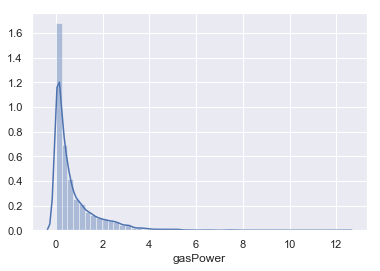

In [12]:
sns.distplot(data['gasPower'])

# Preprocessing, data to lstm format

In [13]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.7 # This acctually is the train size, oops.
target_column = 'gasPower'

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column=target_column, scale_X=True)
X_train.shape

(4326, 120, 9)

In [14]:
X_train = X_train[:4325]
X_test= X_test[:1785]

y_train = y_train[:4325]
y_test= y_test[:1785]

"""
Check if this is the correct goal!!!!!!
"""
#y_train = y_train[::5] # take only each 5th item from the array
#y_test = y_test[::5]

len(y_train), len(y_test)

(4325, 1785)

In [15]:
# N_sample to lookback
lookback_n_samples= 5

# Some calculations for the reshaping
sequences_length_train = int((X_train.shape[0] / lookback_n_samples))
sequences_length_test = int((X_test.shape[0] / lookback_n_samples))

sequences_length_train, sequences_length_test

(865, 357)

In [16]:
#X_train = X_train.reshape(sequences_length_train, lookback_n_samples, X_train.shape[1], X_train.shape[2], 1)
#X_test = X_test.reshape(sequences_length_test, lookback_n_samples, X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

X_train.shape, X_test.shape

((4325, 120, 9), (1785, 120, 9))

# Enlarge the images

# Creating sliding view over the images

In [17]:
X_train.shape, y_train.shape

((4325, 120, 9), (4325,))

In [18]:
X_train[0][-1:]

array([[ 0.86084585,  1.4913013 ,  1.49269064, -1.44552755,  2.15473258,
        -0.07188603, -0.50290825, -0.98170873,  3.8141324 ]])

In [19]:
y_train[0]

4.018259525299072

In [22]:
def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [23]:
from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers.normalization import BatchNormalization

from keras.layers import Input
from keras.models import Model

dropout = 0.2

# CNN Model

In [24]:
cnn = Sequential() # This model is supposed to look at single images

#cnn.add(Conv2D(
#        filters=16,
#        kernel_size=(24, 60),
#        padding='same', kernel_initializer='TruncatedNormal'))
#cnn.add(LeakyReLU())
#cnn.add(BatchNormalization())
#cnn.add(Dropout(dropout))

#cnn.add(Conv2D(
#        filters=16,
#        kernel_size=(10, 10),
#        padding='same', kernel_initializer='TruncatedNormal'))
#cnn.add(LeakyReLU())
#cnn.add(BatchNormalization())
#cnn.add(Dropout(dropout))

cnn.add(Conv2D(
        filters=16,
        kernel_size=(2, 2),
        padding='same', kernel_initializer='TruncatedNormal'))
cnn.add(LeakyReLU())
cnn.add(BatchNormalization())

#cnn.add(MaxPooling2D(pool_size=(2, 2))) # Increases training speed by 2.5 times!

cnn.add(Flatten())

ValueError: The first layer in a Sequential model must get an `input_shape` or `batch_input_shape` argument.

# RNN Model

In [ ]:
rnn = Sequential()

rnn.add(CuDNNGRU(512, return_sequences=False, kernel_initializer='TruncatedNormal'))
rnn.add(LeakyReLU())
rnn.add(Dropout(dropout))

# Dense Model

In [ ]:
dense = Sequential()
dense.add(Dense(128, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(64, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(16, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(16, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(16, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(16, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

dense.add(Dense(16, kernel_initializer='TruncatedNormal'))
dense.add(LeakyReLU())
dense.add(Dropout(dropout))

# output
dense.add(Dense(1))

# Put it all together

In [ ]:
X_train.shape

In [ ]:
main_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # Data has been reshaped to (800, 5, 120, 60, 1)
reshaped_to_smaller_images = Reshape(target_shape=(24, 5, X_train.shape[2], 1))(main_input)

model = TimeDistributed(cnn)(reshaped_to_smaller_images) # this should make the cnn 'run' 5 times?
model = rnn(model) # combine timedistributed cnn with rnn
model = dense(model) # add dense

# Final model

In [ ]:
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()

# Learning rate finder

multi_model.fit(X_train, y_train, callbacks=[lr_finder] )

## Plot LR informartion

In [ ]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 150 #135
bs = 2**10
print('Batch size: ', bs)

# Choose the highest learning rate where the loss is still improving by a lot
lr=6e-4

# 0.05 0.9 0 True
#sgd = SGD(lr=lr, momentum=0.9, decay=0, nesterov=True) # 0.005
sgd = SGD(lr=lr)
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

epoch_size = 3

# For more info see: https://www.jeremyjordan.me/nn-learning-rate/
# Not applying it correctly? 19-11-2018 20.24
schedule = SGDRScheduler(min_lr=1e-4, # Pick the range where LR is ideal
                         max_lr=5e-2,
                         steps_per_epoch=np.ceil(epoch_size/bs),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

In [281]:
"""
adam
lr 7e-3
min val mape 47.5
"""

# compile & fit
final_model.compile(optimizer=nadam, loss = ['mse'], metrics=[mape, smape, 'mse'])

early_stopping_monitor = EarlyStopping(patience=5000)


final_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[early_stopping_monitor, PlotLossesKeras()])

KeyboardInterrupt: 

# Create plot

In [282]:
y_preds = final_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it


1785/1785 [==============================] - 0s 153us/step
FINISHED


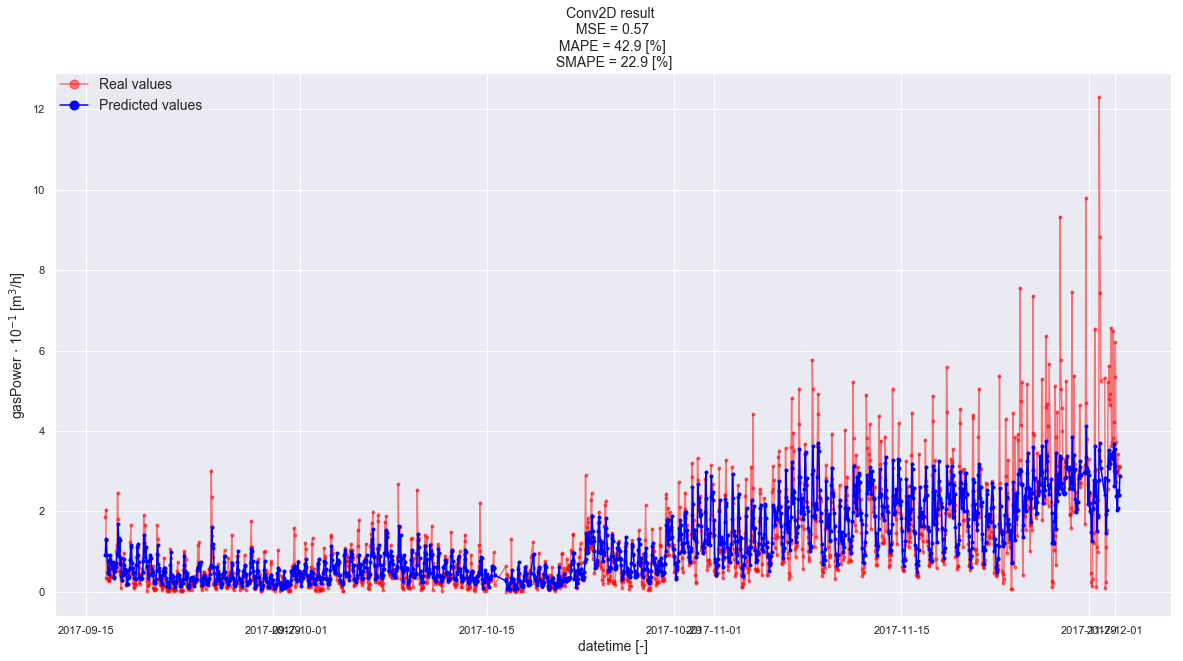

In [283]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result, _ = final_model.evaluate(X_test, y_test)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly.png', dpi=300)
print('FINISHED')

# Make the same plot, but downsample the results to a day

In [284]:
# Get results, put it in a dataframe

y_preds = final_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

#result.to_csv('model _results _data/CNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1785,)


In [285]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'Conv2D result \n MSE = 20.52 \n MAPE = 12.5 [%] \n SMAPE = 6.2 [%]')

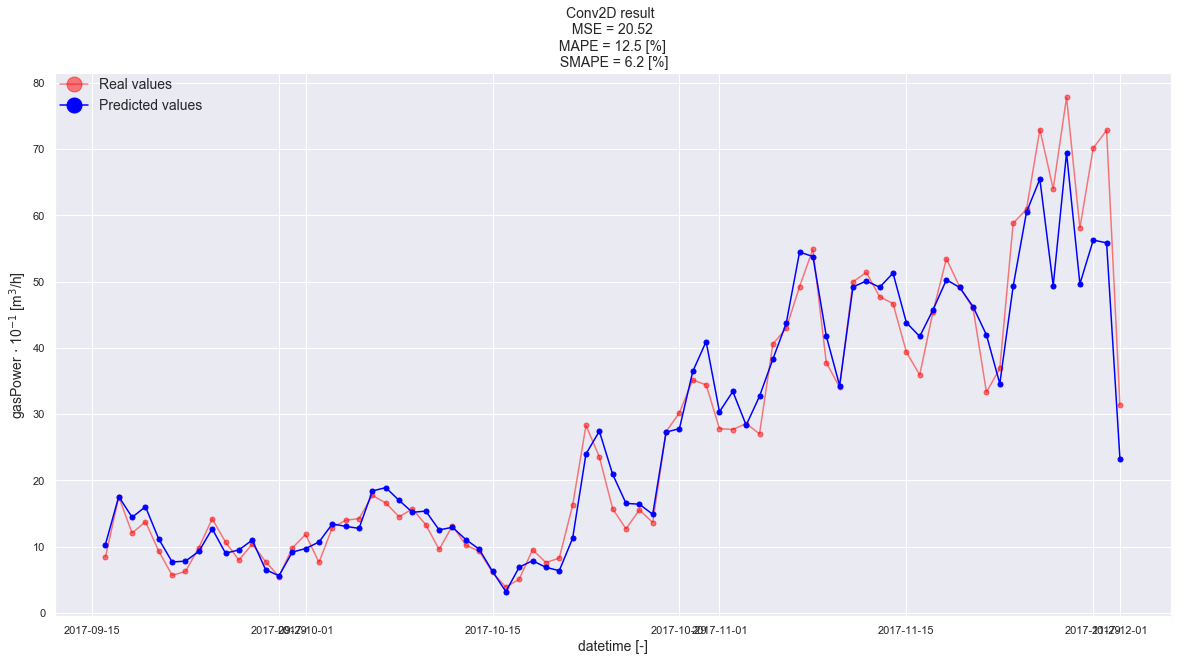

In [286]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)

# Save the model

In [1]:
model.save('model.h5')
model.save_weights('model_weights.h5')
print('FINISHED')

NameError: name 'model' is not defined

# Load the model

In [15]:
from keras.models import load_model
model = load_model('model.h5') # Load the architecture
moel = model.load_weights('model_weights.h5') # Set the weights

model.compile(optimizer='adam', loss = ['mse'], metrics=[mape, smape]) # Compile it (could also set to multi_gpu before this)
print('FINISHED')

FINISHED


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
model.summary()